In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip  # downloading the data

--2021-04-20 04:34:21--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  17.8MB/s    in 7.6s    

2021-04-20 04:34:29 (11.8 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [ ]:
!unzip EuroSAT.zip   # unzipping the dataset

In [ ]:
# importing all the libraries required
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np 
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


In [ ]:
# to store the entire training data
x_train=[]
y_train=[]
labels=[]

In [ ]:
# load entire training data of size 100 x 100 x 3 to main memory only for resnet and inception network
l=os.listdir('/content/2750')
string='/content/2750/'
count=0
for i in l:
  l1=os.listdir(string+i+'/')
  for j in l1:
    img=cv2.imread(string+i+'/'+j)
    img=cv2.resize(img,(100,100))
    x_train.append(img)
    y_train.append(count)
  count+=1
  labels.append(i)  
  
  

In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.framework import constant_op
from tensorflow.python.training.optimizer import Optimizer
import tensorflow as tf

#Coin betting optimizer without a learning rate
class COCOB(Optimizer):
    def __init__(self, alpha=100, use_locking=False, name='COCOB'):
        
        super(COCOB, self).__init__(use_locking, name)
        self._alpha = alpha

    def _create_slots(self, var_list):
        for v in var_list:
            with ops.colocate_with(v):
                gradients_sum = constant_op.constant(0, 
                                                     shape=v.get_shape(),
                                                     dtype=v.dtype.base_dtype)
                grad_norm_sum = constant_op.constant(0, 
                                                     shape=v.get_shape(),
                                                     dtype=v.dtype.base_dtype)
                L = constant_op.constant(1e-8, shape=v.get_shape(), dtype=v.dtype.base_dtype)
                tilde_w = constant_op.constant(0.0, shape=v.get_shape(), dtype=v.dtype.base_dtype)
                reward = constant_op.constant(0.0, shape=v.get_shape(), dtype=v.dtype.base_dtype)

            self._get_or_make_slot(v, L, "L", self._name)
            self._get_or_make_slot(v, grad_norm_sum, "grad_norm_sum", self._name)
            self._get_or_make_slot(v, gradients_sum, "gradients_sum", self._name)
            self._get_or_make_slot(v, tilde_w, "tilde_w", self._name)
            self._get_or_make_slot(v, reward, "reward", self._name)

    def _apply_dense(self, grad, var):
        gradients_sum = self.get_slot(var, "gradients_sum")
        grad_norm_sum = self.get_slot(var, "grad_norm_sum")
        tilde_w = self.get_slot(var, "tilde_w")
        L = self.get_slot(var, "L")
        reward = self.get_slot(var, "reward")

        L_update = tf.maximum(L,tf.abs(grad))
        gradients_sum_update = gradients_sum + grad
        grad_norm_sum_update = grad_norm_sum + tf.abs(grad)
        reward_update = tf.maximum(reward-grad*tilde_w,0)
        new_w = -gradients_sum_update/(L_update*(tf.maximum(grad_norm_sum_update+L_update,self._alpha*L_update)))*(reward_update+L_update)
        var_update = var-tilde_w+new_w
        tilde_w_update=new_w
        
        gradients_sum_update_op = state_ops.assign(gradients_sum, gradients_sum_update)
        grad_norm_sum_update_op = state_ops.assign(grad_norm_sum, grad_norm_sum_update)
        var_update_op = state_ops.assign(var, var_update)
        tilde_w_update_op = state_ops.assign(tilde_w, tilde_w_update)
        L_update_op = state_ops.assign(L, L_update)
        reward_update_op = state_ops.assign(reward, reward_update)

        return control_flow_ops.group(*[gradients_sum_update_op,
                             var_update_op,
                             grad_norm_sum_update_op,
                             tilde_w_update_op,
                             reward_update_op,
                             L_update_op])

    def _apply_sparse(self, grad, var):
        return self._apply_dense(grad, var)

    def _resource_apply_dense(self, grad, handle):
        return self._apply_dense(grad, handle)

In [ ]:
# convert dataset from list to array numpy
x_train=np.array(x_train)
y_train=np.array(y_train)

In [ ]:
# convert labels to categories and float32
y_train=tf.keras.utils.to_categorical(y_train,num_classes=10,dtype='float32')

In [ ]:
# convert x-train to float32
x_train=np.array(x_train,dtype='float32')

In [ ]:
# shuffle the dataset
x_train,y_train=shuffle(x_train,y_train)

In [ ]:
# cross validation dataset with train-57% test-40% validation=3% 
x_1,x_test,y_1,y_test=train_test_split(x_train,y_train,test_size=0.4,shuffle=False)
del x_train
del y_train
x_tr,x_cv,y_tr,y_cv=train_test_split(x_1,y_1,test_size=0.05,shuffle=False)
del x_1
del y_1

In [ ]:
# do data augmentation of training data with datagen and testing and validation data with datagentest
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True,
        rescale=1./255)  # randomly flip images

datagentest=ImageDataGenerator(rescale=1./255)
datagentest.fit(x_test)
datagentest.fit(x_cv)
datagen.fit(x_tr)

#ResNet50 with shape 100 x 100 

In [ ]:
resnet = ResNet50(input_shape=(100,100,3), weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# inserted our dense network with resnet without last layers
modelresnet=tf.keras.models.Sequential()
modelresnet.add(resnet)
# our network starts from here
modelresnet.add(Flatten())
modelresnet.add(Dense(1024,activation=tf.keras.layers.LeakyReLU(0.3)))
modelresnet.add(Dropout(0.5))
modelresnet.add(Dense(512,activation=tf.keras.layers.LeakyReLU(0.3)))
modelresnet.add(Dense(256,activation=tf.keras.layers.LeakyReLU(0.3)))
modelresnet.add(Dropout(0.5))
modelresnet.add(tf.keras.layers.Dense(10,activation='softmax'))


In [ ]:
modelresnet.compile(optimizer=COCOB(),loss='categorical_crossentropy',metrics=['accuracy'])
history=modelresnet.fit(datagen.flow(x_tr,y_tr,batch_size=32),epochs=30,verbose=1,validation_data=datagentest.flow(x_test,y_test))

Epoch 1/30
481/481 [==============================] - 175s 262ms/step - loss: 8.7670 - accuracy: 0.2564 - val_loss: 4.8542 - val_accuracy: 0.1120
Epoch 2/30
481/481 [==============================] - 124s 257ms/step - loss: 1.4114 - accuracy: 0.4718 - val_loss: 2.4868 - val_accuracy: 0.2952
Epoch 3/30
481/481 [==============================] - 124s 257ms/step - loss: 1.2577 - accuracy: 0.5261 - val_loss: 0.8838 - val_accuracy: 0.6830
Epoch 4/30
481/481 [==============================] - 124s 257ms/step - loss: 1.0042 - accuracy: 0.6497 - val_loss: 1.2715 - val_accuracy: 0.6232
Epoch 5/30
481/481 [==============================] - 124s 257ms/step - loss: 0.8557 - accuracy: 0.7020 - val_loss: 0.5408 - val_accuracy: 0.8124
Epoch 6/30
481/481 [==============================] - 124s 257ms/step - loss: 0.7336 - accuracy: 0.7489 - val_loss: 0.6836 - val_accuracy: 0.7707
Epoch 7/30
481/481 [==============================] - 123s 257ms/step - loss: 0.6238 - accuracy: 0.7890 - val_loss: 0.5349 -

In [ ]:
test_loss,test_accuracy=modelresnet.evaluate(datagentest.flow(x_cv,y_cv))  # test with the cross validation data
print('accuracy=',test_accuracy)
print('test_loss=',test_loss)

26/26 [==============================] - 1s 54ms/step - loss: 0.1209 - accuracy: 0.9642
accuracy= 0.9641975164413452
test_loss= 0.12092258781194687


#Inception Network

In [ ]:
xception=Xception(weights='imagenet', include_top=False,input_shape=(100,100,3))

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
# we have sandwitched xception with our model and fine tuned
modelxception=tf.keras.models.Sequential()
modelxception.add(xception)
# our model starts from here
modelxception.add(Flatten())
modelxception.add(Dense(1024,activation=tf.keras.layers.LeakyReLU(0.3)))
modelxception.add(Dropout(0.5))
modelxception.add(Dense(512,activation=tf.keras.layers.LeakyReLU(0.3)))
modelxception.add(Dense(256,activation=tf.keras.layers.LeakyReLU(0.3)))
modelxception.add(Dropout(0.5))
modelxception.add(tf.keras.layers.Dense(10,activation='softmax'))


In [ ]:
modelxception.compile(optimizer=COCOB(),loss='categorical_crossentropy',metrics=['accuracy'])
history=modelxception.fit(datagen.flow(x_tr,y_tr,batch_size=32),epochs=30,verbose=1,validation_data=datagentest.flow(x_test,y_test))

Epoch 1/30
481/481 [==============================] - 133s 246ms/step - loss: 2.3410 - accuracy: 0.2323 - val_loss: 1.8224 - val_accuracy: 0.2949
Epoch 2/30
481/481 [==============================] - 117s 242ms/step - loss: 0.9900 - accuracy: 0.6397 - val_loss: 0.4977 - val_accuracy: 0.8883
Epoch 3/30
481/481 [==============================] - 116s 242ms/step - loss: 0.4102 - accuracy: 0.8860 - val_loss: 0.1693 - val_accuracy: 0.9510
Epoch 4/30
481/481 [==============================] - 116s 242ms/step - loss: 0.2659 - accuracy: 0.9264 - val_loss: 0.1217 - val_accuracy: 0.9618
Epoch 5/30
481/481 [==============================] - 116s 242ms/step - loss: 0.2009 - accuracy: 0.9423 - val_loss: 0.2295 - val_accuracy: 0.9303
Epoch 6/30
481/481 [==============================] - 116s 242ms/step - loss: 0.1660 - accuracy: 0.9518 - val_loss: 0.0915 - val_accuracy: 0.9706
Epoch 7/30
481/481 [==============================] - 116s 242ms/step - loss: 0.1444 - accuracy: 0.9600 - val_loss: 0.0854 -

In [ ]:
test_loss,test_accuracy=modelxception.evaluate(datagentest.flow(x_cv,y_cv))  # test with the cross validation data
print('accuracy=',test_accuracy)
print('test_loss=',test_loss)

26/26 [==============================] - 1s 46ms/step - loss: 0.0620 - accuracy: 0.9864
accuracy= 0.9864197373390198
test_loss= 0.062034621834754944


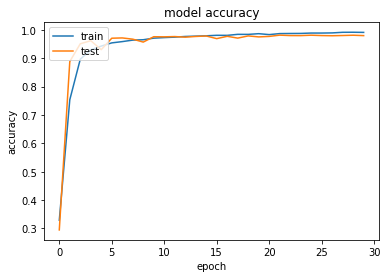

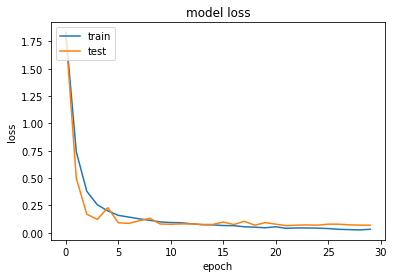

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
modelxception.save('xception_model_cocob.h5')

In [ ]:
tf.keras.models.save_model(
    modelxception, '/content/', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


In [ ]:
modelxception.save_weights('weights.h5')
symbolic_weights = getattr(modelxception.optimizer, 'weights')
weight_values = K.batch_get_value(symbolic_weights)
with open('optimizer.pkl', 'wb') as f:
    pickle.dump(weight_values, f)

NotImplementedError: ignored